In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import scipy.linalg as sl
import scipy.stats as sps
from scipy.constants import golden_ratio

import json, pickle, os, corner, glob, sys
from collections import defaultdict, OrderedDict
from copy import deepcopy
import pandas as pd
from astropy.time import Time
import astropy.units as u

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [3]:
color_cycle_wong = ['#000000','#E69F00','#009E73','#56B4E9','#0072B2','#F0E442','#D55E00','#CC79A7']
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle_wong)
def get_fig_size(width=15,scale=1.):
    #width = 3.36 # 242 pt
    base_size = np.array([1, 1/scale/golden_ratio])
    fig_size = width * base_size
    return(fig_size)
mpl.rcParams['figure.figsize'] = get_fig_size()
mpl.rcParams['text.usetex'] = False
mpl.rc('font',**{'family':'serif','serif':['Times New Roman']})
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
#mpl.rcParams["figure.dpi"] = 300

In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
#top_path_idx = splt_path.index("akaiser")
top_path_idx = splt_path.index("nanograv")
top_dir = "/".join(splt_path[0 : top_path_idx + 1])

In [5]:
la_f_path = top_dir + "/la_forge"
e_e_path = top_dir + "/enterprise_extensions/"
enterprise_path = top_dir + "/enterprise"
sys.path.insert(0, la_f_path)
sys.path.insert(0, e_e_path)
sys.path.insert(0, top_dir + "/enterprise_timing")
sys.path.insert(0, enterprise_path)

In [6]:
import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import utils
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals import deterministic_signals

PINT not installed. Will use libstempo instead.


In [7]:
import la_forge
import la_forge.diagnostics as dg
from la_forge.core import TimingCore
from la_forge.core import Core

import nltm_plot_utils_v4 as nltm_plt
from nltm_J0340_setup_pta_v1 import pta_setup

In [8]:
psr_name = 'J0340+4130'#'J1640+2224'#'J2043+1711'#'J2317+1439' 'J1909-3744'
parfile = top_dir + f"/9yr/par/{psr_name}_NANOGrav_9yv1.gls.par"
timfile = top_dir + f"/9yr/tim/{psr_name}_NANOGrav_9yv1.tim"
ephem = 'DE421'
exclude_params = ['lnpost','lnlike','chain_accept','pt_chain_accept']

psr = Pulsar(parfile, timfile, ephem=ephem, clk=None, drop_t2pulsar=False)

ducks 2!
/home/andrew/Documents/Research/nanograv/enterprise_timing/residual_checking/ent_t2_desmat.npz


In [9]:
ptypes = ["normalized" for ii in range(len(psr.t2pulsar.pars()))]
tm_params_orig = OrderedDict(
        zip(
            psr.t2pulsar.pars(),
            map(
                list,
                zip(
                    np.longdouble(psr.t2pulsar.vals()),
                    np.longdouble(psr.t2pulsar.errs()),
                    ptypes,
                ),
            ),
        )
    )

In [10]:
[print(p,z,e) for p,z,e in zip(psr.t2pulsar.pars(),psr.t2pulsar.vals(),psr.t2pulsar.errs())];

ELONG 1.0928215436402511194 0.0
ELAT 0.372356825973707325 nan
F0 303.0909794334667708 5.760699999999999879e-12
F1 -6.501604154599e-16 2.1133269239020001296e-18
PMELONG -2.4185 0.8314000000000000279
PMELAT -4.2499 1.3380000000000000782
PX 0.6837 0.69620000000000004103
FD1 3.21433466e-05 1.853543770000000083e-06
DMX_0001 -0.00568289474 0.00032399321199999997923
DMX_0002 -0.00552085223 0.00029977501100000001916
DMX_0003 -0.00548448238 0.000280141254999999984
DMX_0004 -0.0052418574 0.0002743026410000000176
DMX_0005 -0.00546321846 0.00027164663500000001822
DMX_0006 -0.0058250848 0.0004933091900000000432
DMX_0007 -0.00530310515 0.00029648043799999999198
DMX_0008 -0.00526781796 0.00028518873099999997355
DMX_0009 -0.00517494804 0.00028266689699999998728
DMX_0010 -0.0050663524 0.0002701798849999999903
DMX_0011 -0.00478031918 0.0002806008360000000106
DMX_0012 -0.0050208651 0.00026573736999999997884
DMX_0013 -0.00505935183 0.0002586487010000000121
DMX_0014 -0.00509190447 0.0002561736220000000101


In [11]:
#tmp = psr.t2pulsar.vals()

nltm_plt.refit_errs(psr,tm_params_orig)
for p,t,pt2v in zip(psr.t2pulsar.pars(),tmp,psr.t2pulsar.vals()):
    print(p,t,pt2v)

In [12]:
par = 'PX'
value = 2000
print(tm_params_orig[par][0])
print(tm_params_orig[par][1])
print(tm_params_orig[par][0]+tm_params_orig[par][1]*value)
tm_delay_kwargs = {par:value}
#psr.tm_params_orig

0.6837
0.69620000000000004103
1393.083700000000082


{'PX': 1393.083700000000082}


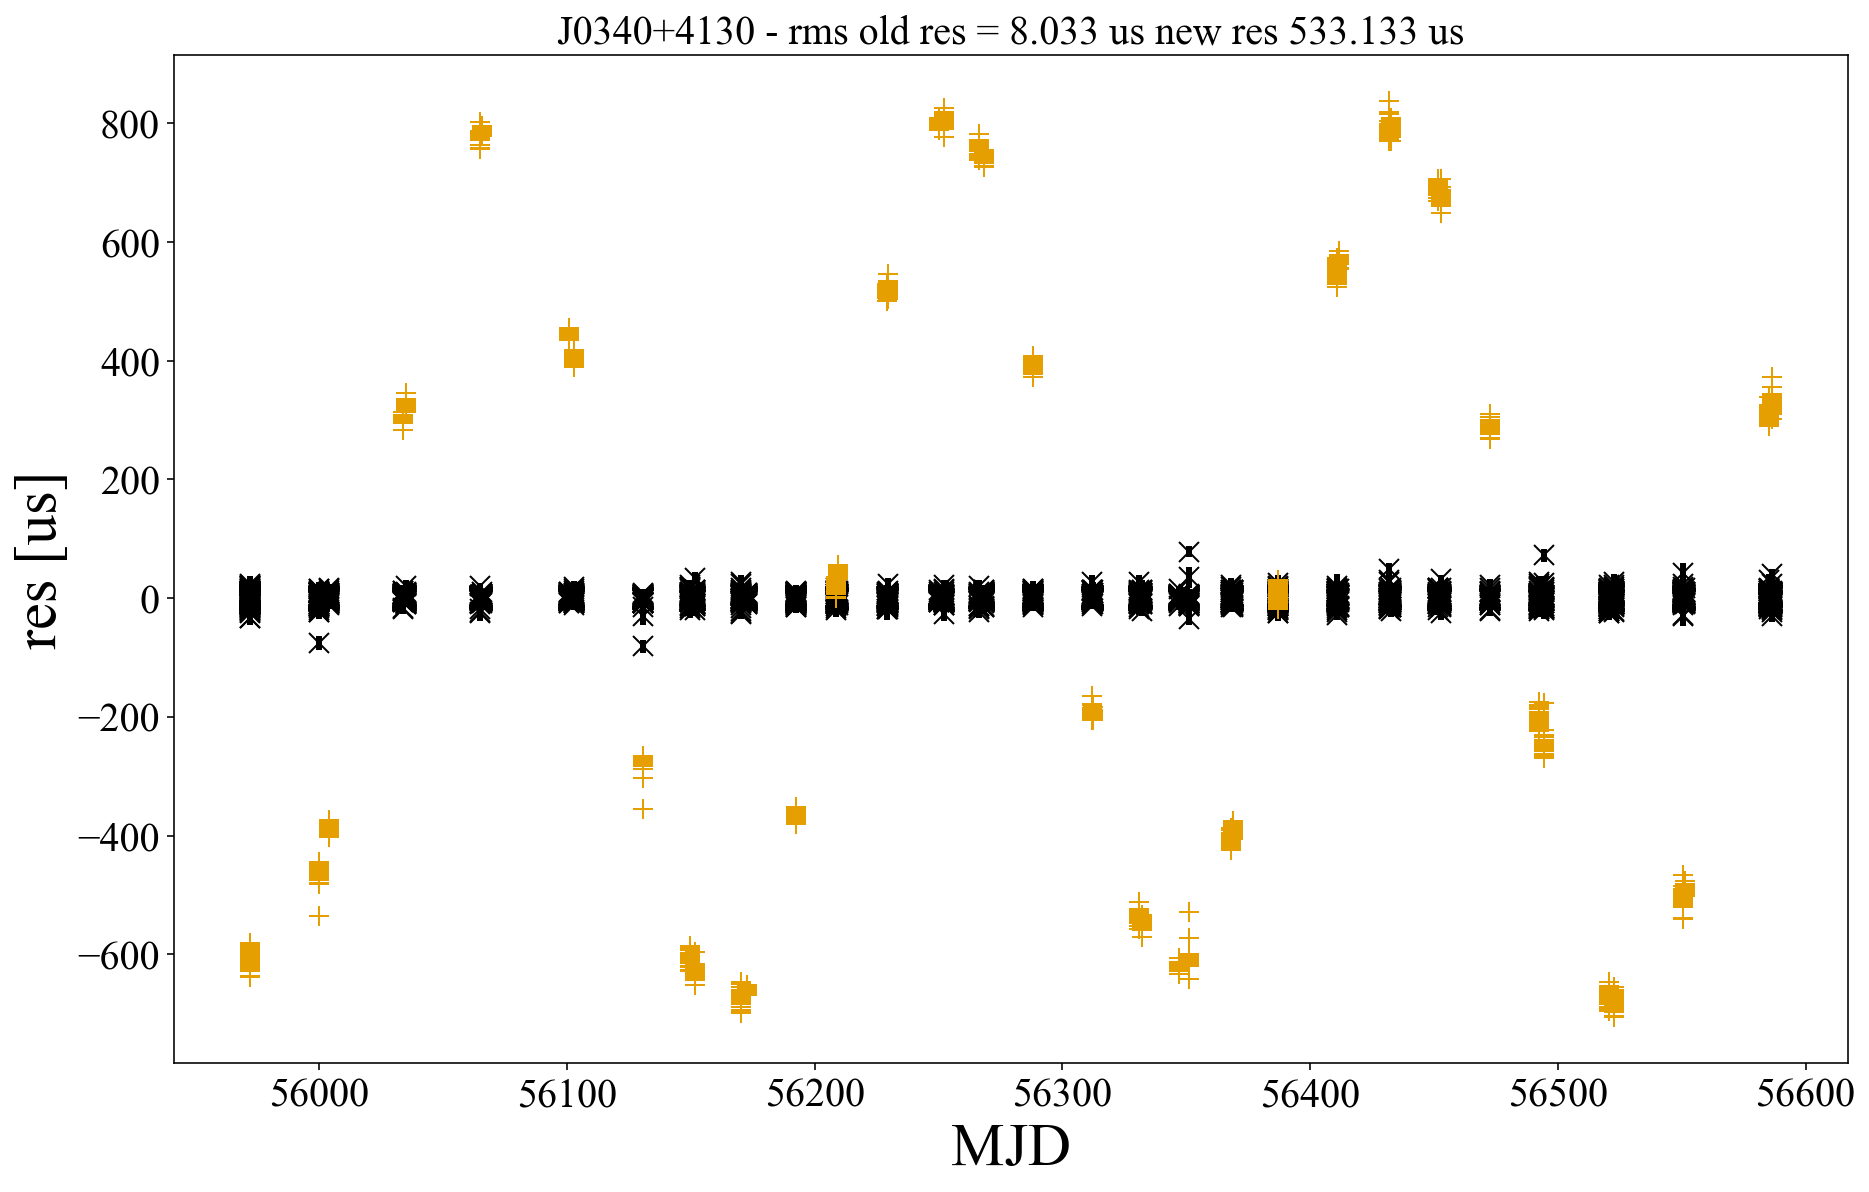

In [13]:
nltm_plt.tm_delay(psr.t2pulsar,tm_params_orig,**tm_delay_kwargs);

```
value = 1000.
for par in psr.t2pulsar.pars():
    tm_delay_kwargs = {par:value}
    nltm_plt.tm_delay(psr.t2pulsar,tm_params_orig,**tm_delay_kwargs);
    plt.show()
```

# Loading runs for MLVs

In [14]:
psr_dir = current_path + f'/{psr_name}/chains/'
chaindir_core_e_e_noRN_varyWN_lin_DMX_FD_JUMP_etc_500_sigma_3 = psr_dir+f'9yr/{psr_name}_uniform_DE421_nltm_ltm_noRN_varyWN_lin_DMX_FD_JUMP_etc_500_sigma_3'
burn=None

core_e_e_noRN_varyWN_lin_DMX_FD_JUMP_etc_500_sigma_3 = TimingCore('_'.join(chaindir_core_e_e_noRN_varyWN_lin_DMX_FD_JUMP_etc_500_sigma_3.split('/')[-2:]),
                              chaindir=chaindir_core_e_e_noRN_varyWN_lin_DMX_FD_JUMP_etc_500_sigma_3,
                              tm_pars_path=chaindir_core_e_e_noRN_varyWN_lin_DMX_FD_JUMP_etc_500_sigma_3+'/orig_timing_pars.pkl',
                              burn=burn)

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 24975
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


In [15]:
burn=None
#mark9
chaindir_PAL2_nltm_ltm_noRN_varyWN_lin_DMX_FD_JUMP_etc_mark9_1 = top_dir + f'/enterprise_timing/{psr_name}/ark_PAL2/PAL2_nltm_ltm_noRN_varyWN_lin_DMX_FD_JUMP_etc_mark9_1'
enterprise_equiv_pars = ['J0340+4130_Rcvr1_2_GUPPI_efac', 'J0340+4130_Rcvr_800_GUPPI_efac',
                        'J0340+4130_Rcvr1_2_GUPPI_log10_ecorr', 'J0340+4130_Rcvr_800_GUPPI_log10_ecorr',
                        'J0340+4130_Rcvr1_2_GUPPI_log10_equad', 'J0340+4130_Rcvr_800_GUPPI_log10_equad',
                        'J0340+4130_timing_model_PMELONG', 'J0340+4130_timing_model_PMELAT',
                        'J0340+4130_timing_model_PX']

In [16]:
#mark9
chain_PAL2_nltm_ltm_noRN_varyWN_lin_DMX_FD_JUMP_etc_mark9_1 = pd.read_csv(chaindir_PAL2_nltm_ltm_noRN_varyWN_lin_DMX_FD_JUMP_etc_mark9_1+'/chain_1.txt',
                                                                        sep='\t', dtype=float, header=None).values
core_PAL2_nltm_ltm_noRN_varyWN_lin_DMX_FD_JUMP_etc_mark9_1 = Core('PAL2_nltm_ltm_noRN_varyWN_lin_DMX_FD_JUMP_etc_mark9_1',
                                                                chain=chain_PAL2_nltm_ltm_noRN_varyWN_lin_DMX_FD_JUMP_etc_mark9_1,
                                                                params=enterprise_equiv_pars.copy(),
                                                                burn=burn)

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 11350
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


In [18]:
#c_PAL2 = core_PAL2_9yr_noRN_vary_WN_noise_only_1
c_PAL2 = core_PAL2_nltm_ltm_noRN_varyWN_lin_DMX_FD_JUMP_etc_mark9_1
#c_PAL2 = core_PAL2_noRN_varyWN_full_nltm_mark9_1
#c_e_e = core_9yr_DE421_noRN_varyWN_noise_only_1
c_e_e = core_e_e_noRN_varyWN_lin_DMX_FD_JUMP_etc_500_sigma_3
#c_e_e = core_9yr_DE421_noRN_varyWN_noise_only_no_tm_1
#c_e_e = core_9yr_DE421_noRN_varyWN_full_nltm_500_sigma_1

In [19]:
c_e_e.params[-2]

'chain_accept'

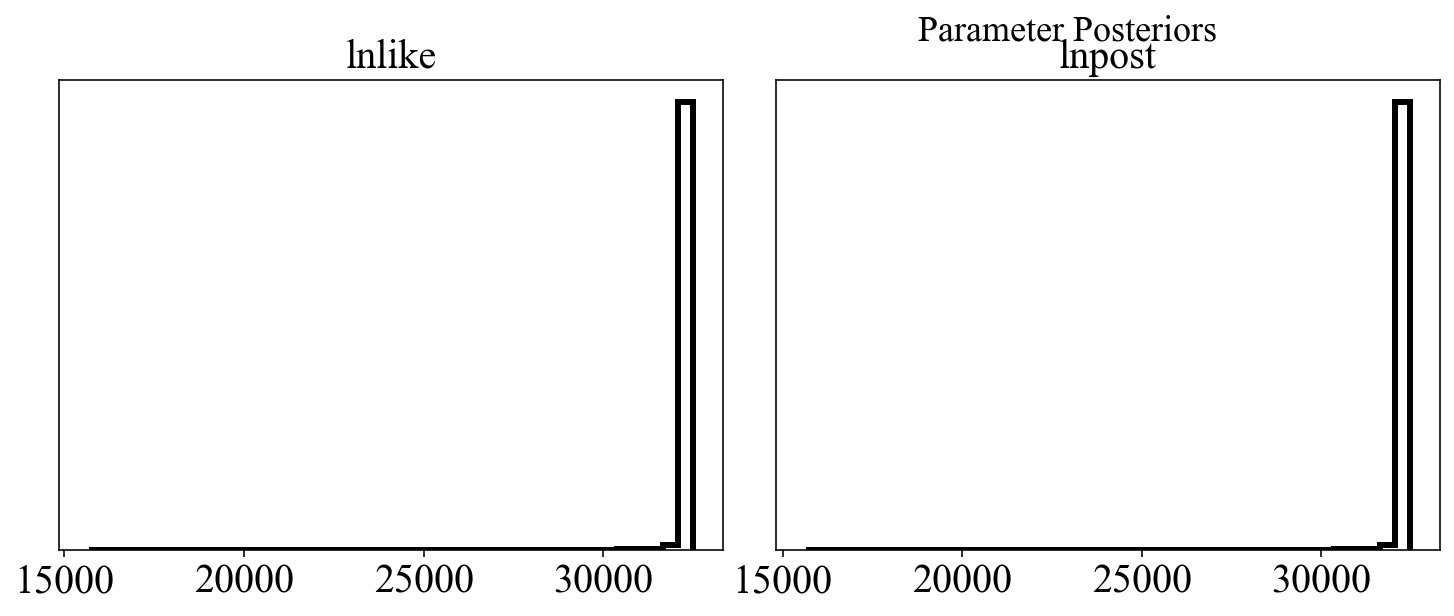

[32491.138411, 32460.271804]


In [20]:
hist_core_kwargs = {'hist':True, 'ncols':3,'title_y':1.03,
                'hist_kwargs':dict(fill=False),'linewidth':3.}
trace_core_kwargs = {'hist':False, 'ncols':3,'title_y':1.05,
                'hist_kwargs':dict(fill=False),'linewidth':3.}
dg.plot_chains(c_e_e,
               pars=['lnlike','lnpost'],
               real_tm_pars=False,
               **hist_core_kwargs)
print([np.max(c_e_e.get_param(x)) for x in ['lnlike','lnpost']])

In [21]:
c_e_e_titles = nltm_plt.get_titles(psr_name,c_e_e)
map_idx_e_e = np.argmax(c_e_e.get_param('lnpost',to_burn=True))
map_dict_e_e = OrderedDict()
map_dict_e_e_scaled = OrderedDict()
mean_dict_e_e = OrderedDict()
for par in c_e_e.params:
    unscaled_param = c_e_e.get_param(par,to_burn=True)
    scaled_param = c_e_e.get_param(par,to_burn=True,tm_convert=False)
    map_dict_e_e_scaled[par] = scaled_param[map_idx_e_e]
    map_dict_e_e[par] = unscaled_param[map_idx_e_e]
    mean_dict_e_e[par] = np.mean(unscaled_param)

In [22]:
tm_params_orig['PX']

[0.6837, 0.69620000000000004103, 'normalized']

In [23]:
map_dict_e_e

OrderedDict([('J0340+4130_Rcvr1_2_GUPPI_efac', 1.1653083923340508),
             ('J0340+4130_Rcvr1_2_GUPPI_log10_ecorr', -7.933830522466152),
             ('J0340+4130_Rcvr1_2_GUPPI_log10_equad', -9.975839783512333),
             ('J0340+4130_Rcvr_800_GUPPI_efac', 1.0918043418926164),
             ('J0340+4130_Rcvr_800_GUPPI_log10_ecorr', -8.314049329096257),
             ('J0340+4130_Rcvr_800_GUPPI_log10_equad', -7.377330422172056),
             ('J0340+4130_timing_model_PMELAT', -4.17865177914288),
             ('J0340+4130_timing_model_PMELONG', -2.3390302472236604),
             ('J0340+4130_timing_model_PX', 0.6475440470430858),
             ('lnpost', 32460.271804),
             ('lnlike', 32491.138411),
             ('chain_accept', 0.325388),
             ('pt_chain_accept', 0.24721)])

hist_core_kwargs = {'hist':True, 'ncols':3,'title_y':1.03,
                'hist_kwargs':dict(fill=False),'linewidth':3.}
dg.plot_chains(c_e_e,
               pars=c_e_e.params,
               titles=c_e_e_titles,
               real_tm_pars=True,
               **hist_core_kwargs)

OrderedDict([('ELONG', [1.0928215436402511194, 0.0, 'normalized']), ('ELAT', [0.372356825973707325, nan, 'normalized']), ('F0', [303.0909794334667708, 5.760699999999999879e-12, 'normalized']), ('F1', [-6.501604154599e-16, 2.1133269239020001296e-18, 'normalized']), ('PMELONG', [-2.4185, 0.8314000000000000279, 'physical']), ('PMELAT', [-4.2499, 1.3380000000000000782, 'physical']), ('PX', [0.6837, 0.69620000000000004103, 'physical']), ('FD1', [3.21433466e-05, 1.853543770000000083e-06, 'normalized']), ('DMX_0001', [-0.00568289474, 0.00032399321199999997923, 'normalized']), ('DMX_0002', [-0.00552085223, 0.00029977501100000001916, 'normalized']), ('DMX_0003', [-0.00548448238, 0.000280141254999999984, 'normalized']), ('DMX_0004', [-0.0052418574, 0.0002743026410000000176, 'normalized']), ('DMX_0005', [-0.00546321846, 0.00027164663500000001822, 'normalized']), ('DMX_0006', [-0.0058250848, 0.0004933091900000000432, 'normalized']), ('DMX_0007', [-0.00530310515, 0.00029648043799999999198, 'normali

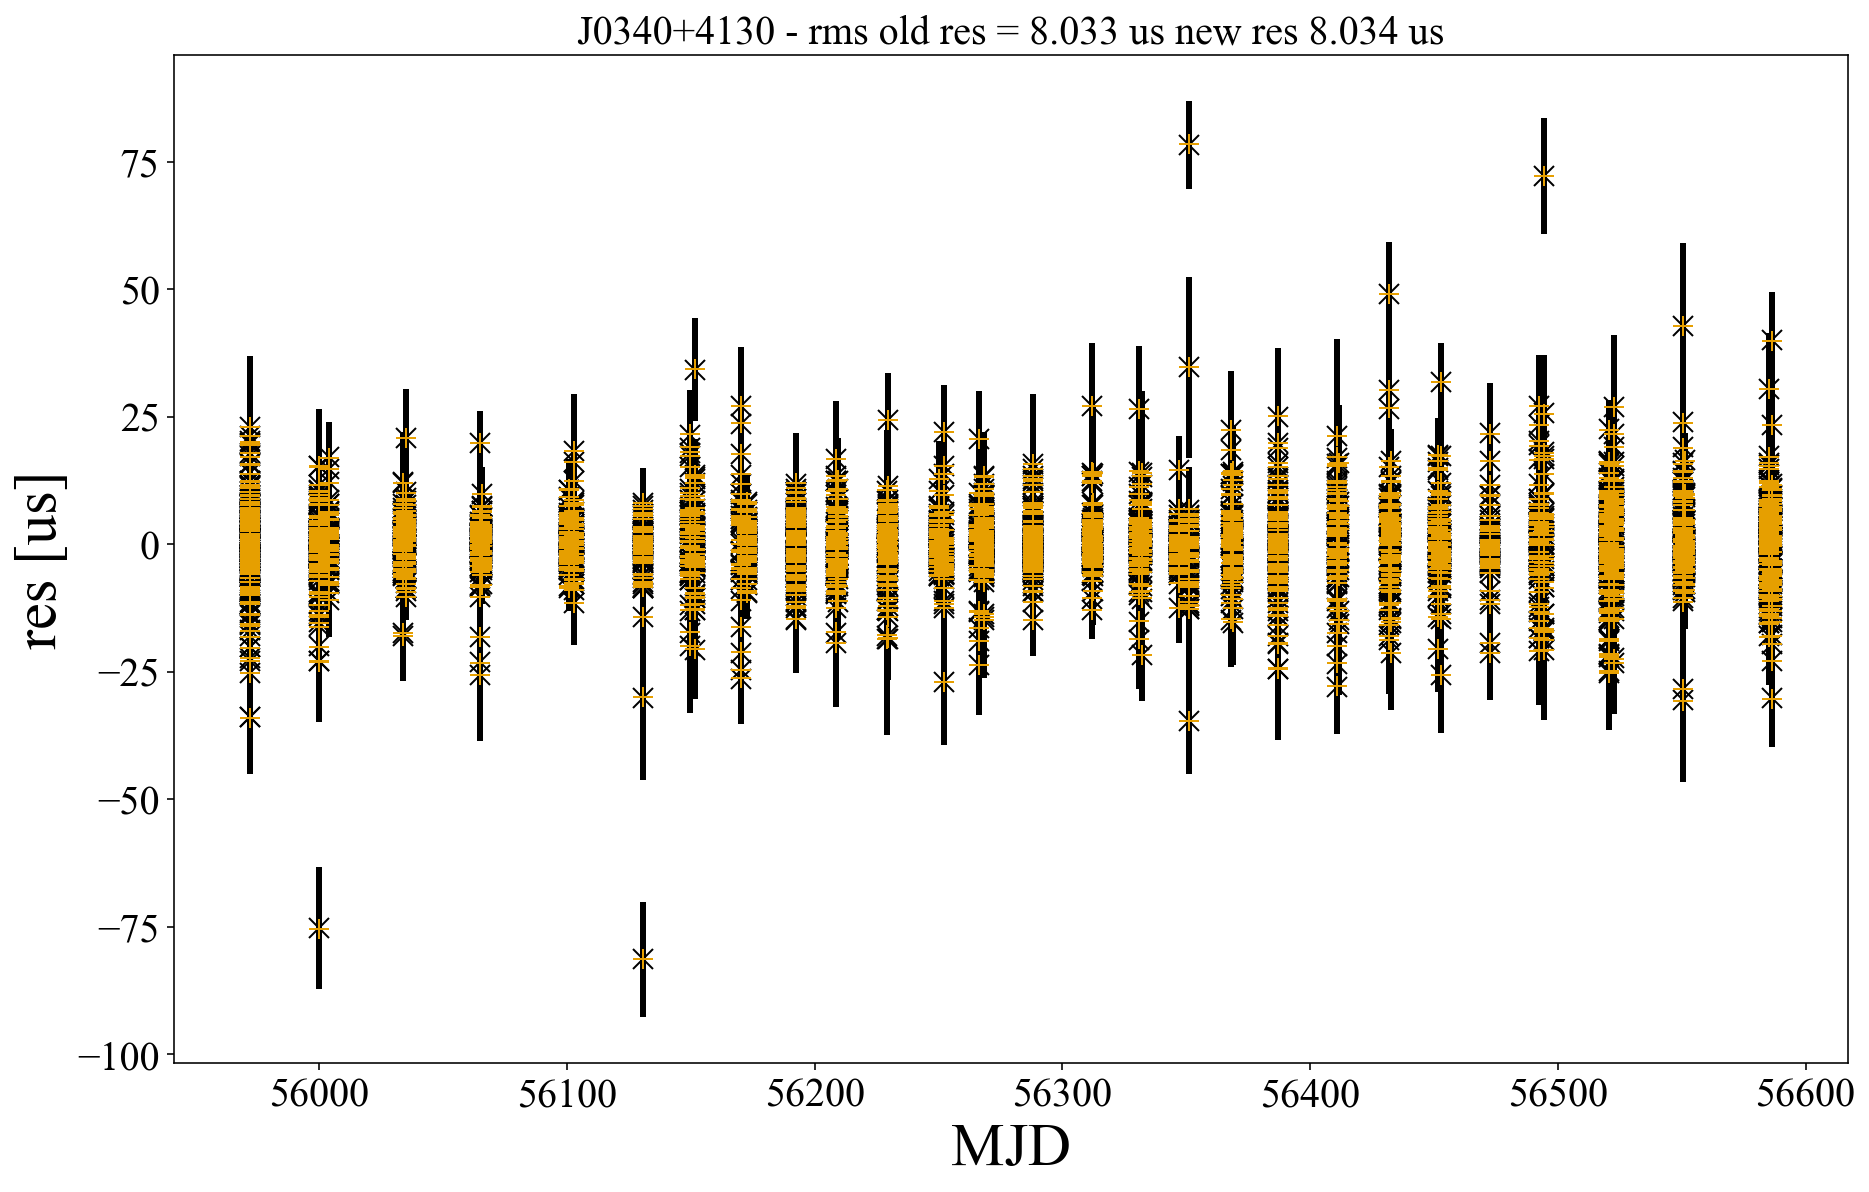

In [24]:
#use_map = True
use_map = True
use_zeros = False
if use_map:
    e_e_dict = deepcopy(map_dict_e_e)
    if use_zeros:
        for p in e_e_dict.keys():
            if 'timing' in p:
                e_e_dict.update({p:tm_params_orig[p.split('_')[-1]][0]})
else:
    e_e_dict = deepcopy(mean_dict_e_e)
    if use_zeros:
        for p in e_e_dict.keys():
            if 'timing' in p:
                e_e_dict.update({p:tm_params_orig[p.split('_')[-1]][0]})
try:
    chain_tm_params_orig = deepcopy(tm_params_orig)
    chain_tm_delay_kwargs = {}
    for par in psr.t2pulsar.pars():
        if par in c_e_e_titles:
            chain_tm_params_orig[par][-1] = 'physical'
            chain_tm_delay_kwargs[par] = e_e_dict[c_e_e.params[c_e_e_titles.index(par)]]
        elif par == 'SINI' and 'COSI' in c_e_e_titles:
            print("COSI added to tm_params_orig for to work with tm_delay.")
            sin_val, sin_err, _ = chain_tm_params_orig[par]
            val = np.longdouble(np.sqrt(1 - sin_val ** 2))
            err = np.longdouble(
                np.sqrt((np.abs(sin_val / val)) ** 2 * sin_err ** 2)
            )
            chain_tm_params_orig['COSI'] = [val, err, "physical"]
            chain_tm_delay_kwargs['COSI'] = e_e_dict[c_e_e.params[c_e_e_titles.index('COSI')]]
    print(chain_tm_params_orig)
    nltm_plt.tm_delay(psr.t2pulsar,chain_tm_params_orig,**chain_tm_delay_kwargs);
    plt.show()
except:
    print("Noise only run? Can't do it.")

In [25]:
c_PAL2_titles = nltm_plt.get_titles(psr_name,c_PAL2)
map_idx_PAL2 = np.argmax(c_PAL2.get_param('lnpost',to_burn=True))
map_dict_PAL2 = OrderedDict()
mean_dict_PAL2 = OrderedDict()
pert_map_dict_PAL2 = OrderedDict()
for par in c_PAL2.params:
    unscaled_param = c_PAL2.get_param(par,to_burn=True)
    pert_map_dict_PAL2[par] = unscaled_param[map_idx_PAL2]+.1*unscaled_param[map_idx_PAL2]
    map_dict_PAL2[par] = unscaled_param[map_idx_PAL2]
    mean_dict_PAL2[par] = np.mean(unscaled_param)

hist_core_kwargs = {'hist':True, 'ncols':3,'title_y':1.03,
                'hist_kwargs':dict(fill=False),'linewidth':3.}
dg.plot_chains(c_PAL2,
               pars=c_PAL2.params,
               titles=c_PAL2_titles,
               real_tm_pars=False,
               **hist_core_kwargs)

{'PMELONG': -2.3719113964803866246, 'PMELAT': -4.0930183759458964587, 'PX': 0.896001675010787868}


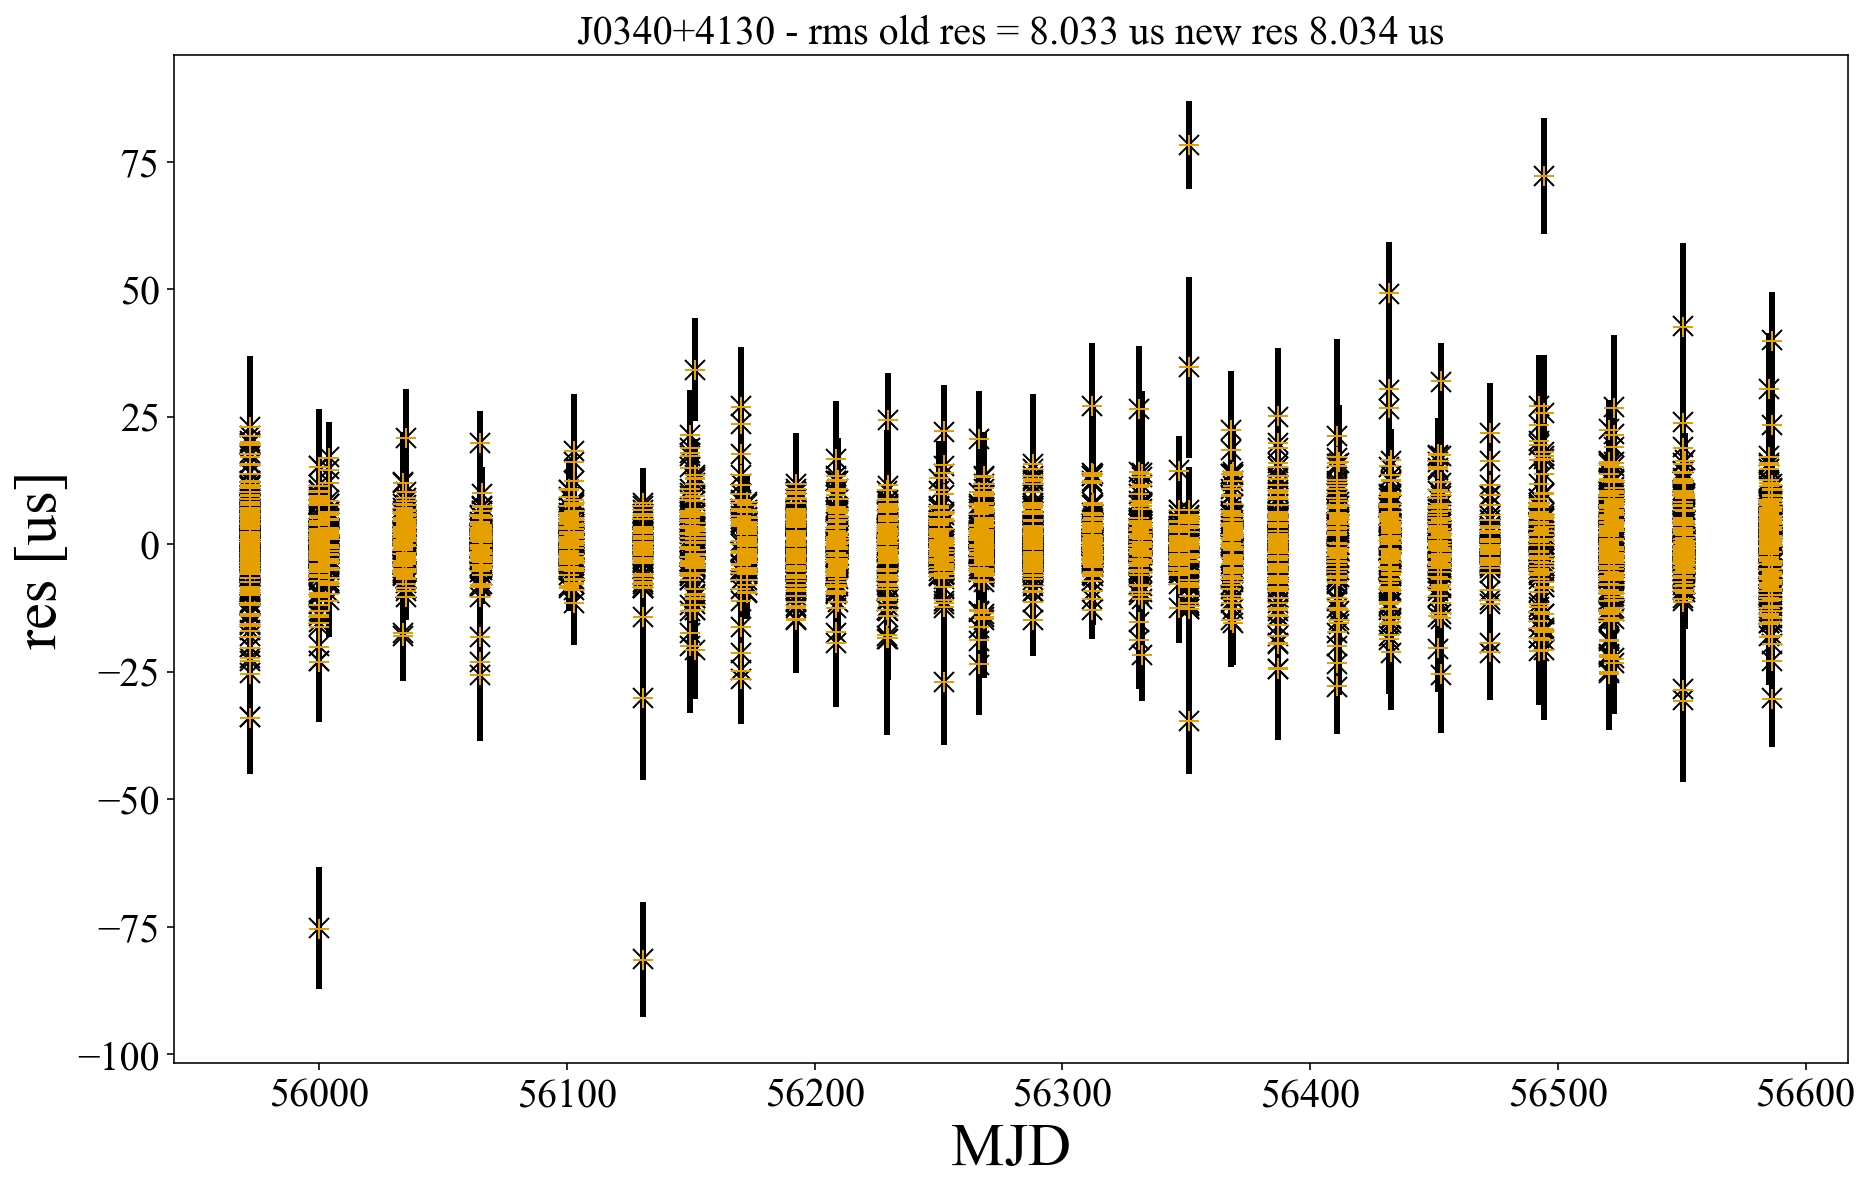

In [26]:
#use_map = True
use_map = False
if use_map:
    PAL2_dict = deepcopy(map_dict_PAL2)
else:
    PAL2_dict = deepcopy(mean_dict_PAL2)
try:
    PAL2_tm_params_orig = deepcopy(tm_params_orig)
    PAL2_tm_delay_kwargs = {}
    for par in psr.t2pulsar.pars():
        if par in c_PAL2_titles:
            PAL2_tm_params_orig[par][-1] = 'physical'
            PAL2_tm_delay_kwargs[par] = PAL2_dict[c_PAL2.params[c_PAL2_titles.index(par)]]
        elif par == 'SINI' and 'COSI' in c_PAL2_titles:
            print("COSI added to tm_params_orig for to work with tm_delay.")
            sin_val, sin_err, _ = PAL2_tm_params_orig[par]
            val = np.longdouble(np.sqrt(1 - sin_val ** 2))
            err = np.longdouble(
                np.sqrt((np.abs(sin_val / val)) ** 2 * sin_err ** 2)
            )
            PAL2_tm_params_orig['COSI'] = [val, err, "physical"]
            PAL2_tm_delay_kwargs['COSI'] = PAL2_dict[c_PAL2.params[c_PAL2_titles.index('COSI')]]

    nltm_plt.tm_delay(psr.t2pulsar,PAL2_tm_params_orig,**PAL2_tm_delay_kwargs);
    plt.show()
except:
    print("Noise only run? Can't do it.")

In [27]:
print(c_PAL2.label)
print(c_e_e.label)

PAL2_nltm_ltm_noRN_varyWN_lin_DMX_FD_JUMP_etc_mark9_1
9yr_J0340+4130_uniform_DE421_nltm_ltm_noRN_varyWN_lin_DMX_FD_JUMP_etc_500_sigma_3


Save map_dicts

```
nltm_timing_run_name = 'PAL2_nltm_ltm_noRN_varyWN_lin_DMX_FD_JUMP_etc_mark9_like_test_1'
nltm_timing_outDir="/home/andrew/Documents/Research/nanograv/enterprise_timing/{}/ark_PAL2/{}".format(psr_name,nltm_timing_run_name)
with open(nltm_timing_outDir+'/map_dict_PAL2.json','w') as f:
    json.dump(map_dict_PAL2,f)
    
with open(nltm_timing_outDir+'/pert_map_dict_PAL2.json','w') as f:
    json.dump(pert_map_dict_PAL2,f)
    
copy_tm_params_orig = deepcopy(tm_params_orig)
for key, val in copy_tm_params_orig.items():
    for i,num in enumerate(val[:-1]):
        copy_tm_params_orig[key][i] = np.double(num)
with open(nltm_timing_outDir+'/tm_params_orig.json','w') as f:
    json.dump(copy_tm_params_orig,f)
```

# Likelihood Comparison

In [28]:
if 'noise_only' in c_PAL2.label:
    tm_var=False
else:
    tm_var=True

if 'no_tm' in c_PAL2.label:
    incTimingModel=False
else:
    incTimingModel=True
    
if 'full' in c_PAL2.label:
    lin_dmx_jump_fd=False
else:
    lin_dmx_jump_fd=True

psr_reload = Pulsar(parfile, timfile, ephem=ephem, clk=None, drop_t2pulsar=False)
pta = pta_setup(psr_reload,datarelease="9yr",psr_name=psr_name,
                tm_var=tm_var,red_var=False,
                white_var=True,fit_remaining_pars=True,
                lin_dmx_jump_fd=lin_dmx_jump_fd,
                tm_linear=False,
                incTimingModel=incTimingModel,Ecorr_gp_basis=False)

ducks 2!
/home/andrew/Documents/Research/nanograv/enterprise_timing/residual_checking/ent_t2_desmat.npz


Non-linearly varying these values:  ['PMELONG', 'PMELAT', 'PX'] 
 in pulsar  J0340+4130
Linearly varying these values:  ['Offset', 'ELONG', 'ELAT', 'F0', 'F1', 'FD1', 'DMX_0001', 'DMX_0002', 'DMX_0003', 'DMX_0004', 'DMX_0005', 'DMX_0006', 'DMX_0007', 'DMX_0008', 'DMX_0009', 'DMX_0010', 'DMX_0011', 'DMX_0012', 'DMX_0013', 'DMX_0014', 'DMX_0015', 'DMX_0016', 'DMX_0017', 'DMX_0018', 'DMX_0019', 'DMX_0020', 'DMX_0021', 'DMX_0022', 'DMX_0023', 'DMX_0024', 'DMX_0025', 'DMX_0026', 'DMX_0027', 'JUMP1']
Using  uniform  prior.
OrderedDict([('ELONG', [1.0928215436402511194, 8.312475227234983854e-10, 'normalized']), ('ELAT', [0.372356825973707325, 2.6585994223154536922e-09, 'normalized']), ('F0', [303.0909794334667708, 5.760699999999999879e-12, 'normalized']), ('F1', [-6.501604154599e-16, 2.1133269239020001296e-18, 'normalized']), ('PMELONG', [-2.4185, 0.8314000000000000279, 'normalized']), ('PMELAT', [-4.2499, 1.3380000000000000782, 'normalized']), ('PX', [0.6837, 0.69620000000000004103, 'physica

In [29]:
newparfile = top_dir + f"/enterprise_timing/{psr_name}/ark_PAL2/{psr_name}_NANOGrav_9yv1.gls.par"
newtimfile = top_dir + f"/enterprise_timing/{psr_name}/ark_PAL2/{psr_name}_NANOGrav_9yv1.tim"
t2_psr = Pulsar(newparfile, newtimfile, ephem=ephem, clk=None, drop_t2pulsar=False)
#pint_psr = Pulsar(newparfile, newtimfile, ephem=ephem, clk=None, drop_pintpsr=False,timing_package='pint')

ducks 2!
/home/andrew/Documents/Research/nanograv/enterprise_timing/residual_checking/ent_t2_desmat.npz


### PAL2 Pulsar init

In [30]:
pal2_path = top_dir + "/PAL2/"
sys.path.insert(0, pal2_path)
import PAL2
from PAL2 import PALpsr
from PAL2 import PALdatafile
import h5py as h5

h5File=f"/home/andrew/Documents/Research/nanograv/enterprise_timing/{psr_name}/ark_PAL2/{psr_name}_h5file.hdf5"
h5df = PALdatafile.DataFile(h5File)

pal2psr = PALpsr.Pulsar()
pal2psr.readFromH5(h5df, psr_name, None, None)
#pal2psr.initLibsTempoObject(ephem='DE421')

[] []


/home/andrew/Documents/Research/nanograv/PAL2/PAL2/PALdatafile.py:142: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = datGroup[field].value


## Section to compare residuals for a grid of parameters

In [31]:
print_df = pd.DataFrame.from_dict({k:v for k,v in map_dict_e_e.items() if k not in exclude_params},orient='index',columns=['map_dict_e_e'])
print_df = print_df.join(pd.DataFrame.from_dict({k:v for k,v in map_dict_PAL2.items() if k not in exclude_params},orient='index',columns=['map_dict_PAL2']))
print_df = print_df.join(pd.DataFrame.from_dict({k:v for k,v in pert_map_dict_PAL2.items() if k not in exclude_params},orient='index',columns=['pert_map_dict_PAL2']))
print([(param.split('_')[-1],tm_params_orig[param.split('_')[-1]]) for param in pert_map_dict_PAL2 if param.split('_')[-1] in tm_params_orig.keys()])
print('')

#copy_map_dict = deepcopy(map_dict_PAL2)
copy_map_dict = deepcopy(pert_map_dict_PAL2)


map_dict_PAL2_4_e_e_scaled = OrderedDict()
scaled_vals = {}
for pparam,pval in copy_map_dict.items():
    if pparam.split('_')[-1] in tm_params_orig.keys() and pparam.split('_')[-1] in ['PMELONG','PMELAT']:
        print(pparam,pval)
        scaled_vals[pparam.split('_')[-1]] = (pval-tm_params_orig[pparam.split('_')[-1]][0])/tm_params_orig[pparam.split('_')[-1]][1]
print(scaled_vals)
for e_eparam,e_eval in map_dict_e_e_scaled.items():
    if e_eparam not in exclude_params:
        if e_eparam.split('_')[-1] in scaled_vals.keys():
            map_dict_PAL2_4_e_e_scaled[e_eparam] = scaled_vals[e_eparam.split('_')[-1]]
        elif e_eparam in copy_map_dict.keys():
            map_dict_PAL2_4_e_e_scaled[e_eparam] = copy_map_dict[e_eparam]
        else:
            print('uh oh')
print('')
print_df = print_df.join(pd.DataFrame.from_dict({k:v for k,v in map_dict_PAL2_4_e_e_scaled.items() if k not in exclude_params},
                                                orient='index',columns=['map_dict_PAL2_4_e_e_scaled']))
print_df

[('PMELONG', [-2.4185, 0.8314000000000000279, 'normalized']), ('PMELAT', [-4.2499, 1.3380000000000000782, 'normalized']), ('PX', [0.6837, 0.69620000000000004103, 'normalized'])]

J0340+4130_timing_model_PMELONG -2.75470752903496
J0340+4130_timing_model_PMELAT -4.546469243634412
{'PMELONG': -0.40438721317652161073, 'PMELAT': -0.22165115368790155187}



,map_dict_e_e,map_dict_PAL2,pert_map_dict_PAL2,map_dict_PAL2_4_e_e_scaled
J0340+4130_Rcvr1_2_GUPPI_efac,1.165308,1.158785,1.274664,1.274664
J0340+4130_Rcvr1_2_GUPPI_log10_ecorr,-7.933831,-7.714524,-8.485976,-8.485976
J0340+4130_Rcvr1_2_GUPPI_log10_equad,-9.975840,-9.662002,-10.628202,-10.628202
J0340+4130_Rcvr_800_GUPPI_efac,1.091804,1.093972,1.203370,1.203370
J0340+4130_Rcvr_800_GUPPI_log10_ecorr,-8.314049,-7.998354,-8.798190,-8.798190
J0340+4130_Rcvr_800_GUPPI_log10_equad,-7.377330,-8.041009,-8.845110,-8.845110
J0340+4130_timing_model_PMELAT,-4.178652,-4.133154,-4.546469,-0.221651
J0340+4130_timing_model_PMELONG,-2.339030,-2.504280,-2.754708,-0.404387
J0340+4130_timing_model_PX,0.647544,0.806028,0.886631,0.886631


# Design Matrix Checks
- In `Enterprise` the `PINT` and `TEMPO2` `Mmat`s and `designmatrix`es are different because `Mmats` are sorted by toa dates (I think)
- `PAL2` doesn't sort `Mmat` so it is the same as the `designmatrix`
- When sorted the same, `TEMPO2 enterprise` and `PAL2` `Mmat`s are the same

print(len(psr.t2pulsar.pars()))
print(len(psr_reload.t2pulsar.pars()))
print(len(t2_psr.t2pulsar.pars()))
design_idxs = ["Offset"] + [p for p in t2_psr.t2pulsar.pars()]
print(design_idxs)

PAL2_t2_desmat_file = f'/home/andrew/Documents/Research/nanograv/enterprise_timing/residual_checking/PAL2_t2_desmat.npz'
PAL2_t2_desmat = np.load(PAL2_t2_desmat_file,allow_pickle=True)
PAL2_t2_desmat_df = pd.DataFrame(PAL2_t2_desmat['desmat'],columns=design_idxs)

PAL2_t2_desmat_df

ent_t2_desmat_file = f'/home/andrew/Documents/Research/nanograv/enterprise_timing/residual_checking/ent_t2_desmat.npz'
ent_t2_desmat = np.load(ent_t2_desmat_file,allow_pickle=True)
ent_t2_desmat_df = pd.DataFrame(ent_t2_desmat['desmat'],columns=design_idxs)

ent_t2_desmat_df

PAL2_isort = np.argsort(pal2psr.toas, kind="mergesort")
PAL2_isort

#Mmat_df_PAL2 = pd.DataFrame(PAL2_lnlike['Mmat'])
Mmat_df_PAL2 = pd.DataFrame(pal2psr.Mmat[PAL2_isort,:],columns=design_idxs)

Mmat_df_PAL2

Mmat_df_t2_psr = pd.DataFrame(t2_psr.Mmat,columns=design_idxs)
desmat_df_t2_psr = pd.DataFrame(t2_psr._designmatrix,columns=design_idxs)
Mmat_df_t2_psr

Mmat_df_pint_psr = pd.DataFrame(pint_psr.Mmat,columns=design_idxs)
desmat_df_pint_psr = pd.DataFrame(pint_psr._designmatrix,columns=design_idxs)
Mmat_df_pint_psr

pd.set_option('display.max_columns', None)
desmat_df_pint_psr.compare(Mmat_df_pint_psr, align_axis=1)

pd.set_option('display.max_columns', None)
Mmat_df_t2_psr.compare(Mmat_df_pint_psr, align_axis=1)

Mmat_df_t2_psr.compare(Mmat_df_PAL2, align_axis=1)

Mmat_df_pint_psr.compare(Mmat_df_PAL2, align_axis=1)

# Likelihood Chunks
- The deterministic residuals in `Enterprise` are calculated inside `SignalCollection`. More importantly, they are calculated by `self._residuals - self.get_delay(params)`. 
    - This means the signal delay from `tm_delay` is subtracted from the _*sorted*_ residuals.
    - Furthermore, the delay is already subtracted, so the signs inside `tm_delay` needed to be flipped to be the same as the `PAL2` version.
- With these corrections, both `logdet_N` and `rNr` are the same between `enterprise` and `PAL2`

In [ ]:
#Unsorted vs sorted residuals depending on which pulsar is used.
plt.plot(range(len(psr_reload.residuals)),psr_reload.residuals/1e6)
plt.plot(range(len(psr_reload.t2pulsar.residuals())),psr_reload.t2pulsar.residuals()/1e6)
plt.show()

In [ ]:
-72586.42163923202, 3749.612420014312

In [ ]:
if use_zeros:
    for p in e_e_dict.keys():
        if 'timing' in p:
            if p.split('_')[-1] in psr_reload.tm_params_orig:
                if psr_reload.tm_params_orig[p.split('_')[-1]][-1] == 'normalized':
                    e_e_dict.update({p:0.0})

In [ ]:
print(e_e_dict)

In [ ]:
grid_params = ['PMELONG', 'PMELAT', 'PX']
#grid_params = ['PMELONG']
scale = 10.
for i,grid_param in enumerate(grid_params):
    if c_e_e.tm_pars_orig[grid_param][-1] == 'physical':
        grid_point = np.float(tm_params_orig[grid_param][0])
        #grid_point = tm_params_orig[grid_param][0]-scale*tm_params_orig[grid_param][1]
        #grid_point = 0.0001
    else:
        grid_point = 0.
        #grid_point = -scale

    #grid_map_dict = deepcopy(map_dict_PAL2_4_e_e_scaled)
    #grid_map_dict = deepcopy(map_dict_e_e)
    grid_map_dict = deepcopy(e_e_dict)
    print(grid_map_dict)
    print(grid_param,grid_point)
    x0 = []
    for key,val in grid_map_dict.items():
        if key not in exclude_params:
            if key.split('_')[-1] == grid_param:
                x0.append(grid_point)
            else:
                x0.append(val)
    print('x0:',x0)
    params = {nm:p for nm, p in zip(grid_map_dict.keys(),x0)}
    print(params)
    """
    for signalcollection in pta._signalcollections:
        print(signalcollection)
        for signal in signalcollection._signals:
            print(signal)
            print(signal.get_ndiag(params))
            if 'Deterministic' in str(type(signal)):
                print('delay pars',signal.delay_params)
                print('psr residuals',psr_reload.residuals)
                print('sigcollect residuals',signalcollection._residuals)
                print('delay',signal.get_delay(params))
                print('detres',signalcollection.get_detres(params))
            elif 'TimingModel' in str(type(signal)):
                #print(dir(signal))
                print(signal.basis_params)
                print(signal.delay_params)
                print(signal.param_names)
                print(signal.get_logsignalprior(params))
                print(signal.get_delay(params))
                print(signal.get_phi(params))
                print(signal.get_phiinv(params))
                print(signal.get_basis(params))
            elif 'EcorrKernelNoise' in str(type(signal)):
                #print('')
                Nvec = signalcollection.get_ndiag(params)
                res = signalcollection.get_detres(params)
                e_e_rNr,e_e_logdet_N = Nvec.solve(res, left_array=res, logdet=True)
                print(e_e_rNr,e_e_logdet_N)
            print('----------------')
        e_e_comp_param = signalcollection.get_detres(params)
        print(signalcollection.get_detres(params))
    #print(pta.get_rNr_logdet(params))
    phiinvs = pta.get_phiinv(params, logdet=True, method='cliques')
    TNrs = pta.get_TNr(params)
    TNTs = pta.get_TNT(params)
    for (k,TNr), TNT, pl in zip(enumerate(TNrs), TNTs, phiinvs):
        print(k)
        e_e_phiinv, e_e_logdet_phi = pl
        e_e_Sigma = TNT + (np.diag(e_e_phiinv) if e_e_phiinv.ndim == 1 else e_e_phiinv)
        cf = sl.cho_factor(e_e_Sigma)
        expval = sl.cho_solve(cf, TNr)
        e_e_logdet_sigma = np.sum(2 * np.log(np.diag(cf[0])))
    """
    grid_lnlike = pta.get_lnlikelihood({nm:p for nm, p in zip(grid_map_dict.keys(),x0)})
    print(grid_lnlike)

In [ ]:
PAL2_isort = np.argsort(pal2psr.toas, kind="mergesort")
PAL2_isort

In [ ]:
lnlike_param = 'PMELONG'
#lnlike_grouped_params = ['savelike_1','savelike_2','savelike_3']
lnlike_grouped_params = ['savelike_1','savelike_2','savelike_3','logdet_Sigma','logdet_Phi','rNr']

e_e_lnlike_save_file = f'/home/andrew/Documents/Research/nanograv/enterprise_timing/residual_checking/{lnlike_param}_grid_lnlike_in_lnlike.npz'
e_e_lnlike = np.load(e_e_lnlike_save_file,allow_pickle=True)

PAL2_lnlike_save_file = f'/home/andrew/Documents/Research/nanograv/enterprise_timing/residual_checking/PAL2_{lnlike_param}_grid_lnlike_in_lnlike.npz'
PAL2_lnlike = np.load(PAL2_lnlike_save_file,allow_pickle=True)

PAL2_res_save_file = f'{top_dir}/enterprise_timing/residual_checking/PAL2_{lnlike_param}_grid_lnlike.npz'
PAL2_param_residual = np.load(PAL2_res_save_file)

df_PAL2_lnlike = pd.DataFrame.from_dict({f'{lnlike_param}_{item}': PAL2_lnlike[item] for item in PAL2_lnlike.files if item in lnlike_grouped_params},
                                        orient='index')
df_PAL2_lnlike = df_PAL2_lnlike.sort_index()

df_e_e_lnlike = pd.DataFrame.from_dict({f'{lnlike_param}_{item}': e_e_lnlike[item] for item in e_e_lnlike.files if item in lnlike_grouped_params},
                                       orient='index')
df_e_e_lnlike = df_e_e_lnlike.sort_index()


In [ ]:
print('PAL2 rNr:',PAL2_lnlike['rNr'])
print('e_e rNr: ',e_e_rNr)
print('--------')
print('PAL2 logdet_N:',PAL2_lnlike['logdet_N'])
print('e_e logdet_N: ',e_e_logdet_N)
print('--------')
print('PAL2 logdet_Phi:',PAL2_lnlike['logdet_Phi'])
print('e_e logdet_Phi: ',e_e_logdet_phi)
print('--------')
print('PAL2 logdet_Sigma:',PAL2_lnlike['logdet_Sigma'])
print('e_e logdet_Sigma: ',e_e_logdet_sigma)
print('--------')
print('PAL2 np.dot(dd,expval2):',np.dot(PAL2_lnlike['dd'],PAL2_lnlike['expval2']))
print('e_e np.dot(TNr,expval): ',np.dot(TNr,expval))

In [ ]:
comp_param = 'detres'
PAL2_tmp_df = pd.DataFrame(PAL2_lnlike[comp_param][PAL2_isort])
PAL2_tmp_df_2 = pd.DataFrame(PAL2_param_residual['new_res_sans_offset'])
e_e_tmp_df = pd.DataFrame(e_e_comp_param)
e_e_tmp_df.compare(PAL2_tmp_df,align_axis=1,keep_equal=True)

In [ ]:
PAL2_lnlike['Nvec']

In [ ]:
#PAL2_tmp_df_3 = pd.DataFrame(PAL2_lnlike['Sigma'])#[PAL2_isort])
#PAL2_tmp_df_3 = pd.DataFrame(PAL2_lnlike['TNT'])#[PAL2_isort])
#PAL2_tmp_df_3 = pd.DataFrame(PAL2_lnlike['Phiinv'])#[PAL2_isort])
PAL2_tmp_df_3 = pd.DataFrame(PAL2_lnlike['dd'])#[PAL2_isort])
#PAL2_tmp_df_3 = pd.DataFrame(PAL2_lnlike['cf'])#[PAL2_isort])
#PAL2_tmp_df_3 = pd.DataFrame(PAL2_lnlike['expval2'])#[PAL2_isort])


#e_e_tmp_df_3 = pd.DataFrame(e_e_Sigma)
#e_e_tmp_df_3 = pd.DataFrame(TNT)
#e_e_tmp_df_3 = pd.DataFrame(e_e_phiinv)
#e_e_tmp_df_3 = pd.DataFrame(cf)
e_e_tmp_df_3 = pd.DataFrame(TNr)
e_e_tmp_df_3.compare(PAL2_tmp_df_3.loc[0:e_e_tmp_df_3.shape[0]-1,0:e_e_tmp_df_3.shape[1]-1],
                     align_axis=1,keep_equal=True)

In [ ]:
#incr = 33
#PAL2_tmp_df_3.loc[0+incr:33+incr,0+incr:33+incr]

In [ ]:
plt.plot(range(len(PAL2_lnlike[comp_param])),PAL2_lnlike[comp_param]/1e-6)
plt.plot(range(len(pal2psr.residuals)),pal2psr.residuals/1e-6)
plt.plot(range(len(e_e_comp_param)),e_e_comp_param/1e-6)
plt.show()

In [ ]:
df_PAL2_lnlike

In [ ]:
print(e_e_lnlike['Nvec'][0])
print(PAL2_lnlike['Nvec'])

In [ ]:
df_e_e_lnlike

In [ ]:
df_e_e_lnlike.compare(df_PAL2_lnlike, align_axis=1,keep_equal=True)

In [ ]:
def simple_plot_res(psr,new_res,ax,pal2=False,label='',**kwargs):
    
    meannewres = np.sqrt(np.mean(new_res ** 2)) / 1e-6
    if pal2:
        t = psr.toas/u.d.to('s')
        #times = Time(sec_times, format='J2000')
        errs = psr.toaerrs
        meanoldres = np.sqrt(np.mean(psr.residuals ** 2)) / 1e-6
        ax.scatter(
            t,
            new_res / 1e-6,
            #yerr=errs[i],
            #marker="x",
            s=100,
            label = f"{label}, res {meannewres:.3f} us",
            **kwargs
        )
    else:
        t, errs = psr.toas(), psr.toaerrs
        meanoldres = np.sqrt(np.mean(psr.residuals() ** 2)) / 1e-6
            
        i = np.argsort(t)
        ax.scatter(
            t[i],
            new_res[i] / 1e-6,
            #yerr=errs[i],
            #marker="x",
            s=100,
            label = f"{label}, res {meannewres:.3f} us",
            **kwargs
        )
    ax.set_ylabel("res [us]")
    ax.set_title(f"{psr.name} - rms old res {meanoldres:.3f} us")
    #plt.legend()

In [ ]:
def simple_plot_res_redux(toas,errs,old_res,new_res,ax,pal2=False,label='',**kwargs):
    meannewres = np.sqrt(np.mean(new_res ** 2)) / 1e-6
    t = toas/u.d.to('s')
    #times = Time(sec_times, format='J2000')
    #errs = psr.toaerrs
    meanoldres = np.sqrt(np.mean(old_res ** 2)) / 1e-6
    ax.scatter(
        t,
        new_res / 1e-6,
        #yerr=errs[i],
        #marker="x",
        s=100,
        label = f"{label}, res {meannewres:.3f} us",
        **kwargs
    )

    ax.set_ylabel("res [us]")
    ax.set_title(f"{psr.name} - rms old res {meanoldres:.3f} us")
    plt.suptitle(f"{psr.name} - rms res {meanoldres:.3f} us",fontsize=25,y=.95)
    #plt.legend()

In [ ]:
-2.4185,-4.2499,0.6837

In [ ]:
grid_param = 'PX'
#MAP
#e_e_save_file = f'{top_dir}/enterprise_timing/residual_checking/{grid_param}_grid_lnlike.npz'
#perturbed
e_e_save_file = f'{top_dir}/enterprise_timing/residual_checking/{grid_param}_grid_lnlike_pert.npz'
e_e_param_residual = np.load(e_e_save_file)
fig,ax = plt.subplots(figsize=(15,10))
simple_plot_res(t2_psr.t2pulsar, t2_psr.t2pulsar.residuals(),ax,label='Original',marker='x')
simple_plot_res(t2_psr.t2pulsar, e_e_param_residual['new_res'],ax,label=f'e_e new {grid_param}',marker='+')
simple_plot_res(t2_psr.t2pulsar, e_e_param_residual['old_res'],ax,label=f'e_e old {grid_param}',marker='1')
simple_plot_res(pal2psr, pal2psr.residuals,ax,pal2=True,label=f'PAL2 old {grid_param}',marker='3')
ax.legend(bbox_to_anchor=(1.,.9))
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(15,10))
grid_param = 'PX'
#MAP
#PAL2_save_file = f'{top_dir}/enterprise_timing/residual_checking/PAL2_{grid_param}_grid_lnlike.npz'
#perturbed
PAL2_save_file = f'{top_dir}/enterprise_timing/residual_checking/PAL2_{grid_param}_grid_lnlike_pert.npz'
PAL2_param_residual = np.load(PAL2_save_file)
simple_plot_res_redux(PAL2_param_residual['toas'],PAL2_param_residual['errs'],PAL2_param_residual['old_res'],
                     PAL2_param_residual['new_res'],ax,pal2=True,label=f'PAL2 new {grid_param}',marker='*')
simple_plot_res_redux(PAL2_param_residual['toas'],PAL2_param_residual['errs'],PAL2_param_residual['old_res'],
                     PAL2_param_residual['old_res'],ax,pal2=True,label=f'PAL2 old {grid_param}',marker='3')
simple_plot_res(pal2psr, pal2psr.residuals,ax,pal2=True,label=f'PAL2 old {grid_param}',marker='3')
ax.legend(bbox_to_anchor=(1.,.9))
plt.show()

grid_param_dict = {'0':{'PMELONG': 0.0, 'PMELAT': -0.1518348065271708, 'PX': 0.5223205378367722},
                   '1':{'PMELONG': -0.30563301210741267, 'PMELAT': 0.0, 'PX': 0.5223205378367722},
                   '2':{'PMELONG': -0.30563301210741267, 'PMELAT': -0.1518348065271708, 'PX': 0.6837}}
grid_params = ['PMELONG', 'PMELAT', 'PX']
fig,axes = plt.subplots(len(grid_params),1,figsize=(15,15),sharex=True)
for (i,grid_param),ax in zip(enumerate(grid_params),axes):
    e_e_save_file = f'{top_dir}/enterprise_timing/residual_checking/{grid_param}_grid_lnlike.npz'
    e_e_param_residual = np.load(e_e_save_file)
    PAL2_save_file = f'{top_dir}/enterprise_timing/residual_checking/PAL2_{grid_param}_grid_lnlike.npz'
    PAL2_param_residual = np.load(PAL2_save_file)
    #nltm_plt.plotres(psr_reload.t2pulsar, e_e_param_residual['new_res'], psr_reload.t2pulsar.residuals(), grid_param_dict[f'{i}'],ms=10)
    #if i == 0:
    simple_plot_res(psr_reload.t2pulsar, psr_reload.t2pulsar.residuals(),ax,label='Original',marker='x')
    simple_plot_res(psr_reload.t2pulsar, e_e_param_residual['new_res'],ax,label=f'e_e new {grid_param}',marker='+')
    simple_plot_res_redux(PAL2_param_residual['toas'],PAL2_param_residual['errs'],PAL2_param_residual['old_res'],
                     PAL2_param_residual['new_res'],ax,pal2=True,label=f'PAL2 new {grid_param}',marker='*')
    simple_plot_res_redux(PAL2_param_residual['toas'],PAL2_param_residual['errs'],PAL2_param_residual['old_res'],
                         PAL2_param_residual['old_res'],ax,pal2=True,label=f'PAL2 old {grid_param}',marker='3')
    ax.legend(bbox_to_anchor=(1.,.9))
    ax.set_title(fr'{grid_param}=val-10*err')
    if i == len(grid_params)-1:
        ax.set_title(fr'{grid_param}$=0.0001$')# without refixing t2psr after fit')
        ax.set_xlabel("MJD")
        #plt.suptitle(f"{psr.name} - rms old res {meanoldres:.3f} us")
        filename = f'{psr_name}_9yr_res_comp_2'
        savefile = f'{top_dir}/enterprise_timing/Figures/{filename}.pdf'
        if not os.path.isfile(savefile):
            print('saving to',savefile)
            plt.savefig(savefile,bbox_inches='tight')
        plt.show()

grouped_params = ['t2psr_vals','t2psr_errs']
grouped_params = ['t2psr_vals']

grid_params = ['PMELONG', 'PMELAT', 'PX']
for i,grid_param in enumerate(grid_params):
    e_e_save_file = f'{top_dir}/enterprise_timing/residual_checking/{grid_param}_grid_lnlike.npz'
    e_e_param_residual = np.load(e_e_save_file)
    PAL2_save_file = f'{top_dir}/enterprise_timing/residual_checking/PAL2_{grid_param}_grid_lnlike.npz'
    PAL2_param_residual = np.load(PAL2_save_file)
    
    if i == 0:
        PAL2_df= pd.DataFrame.from_dict({f'{grid_param}_{item}': PAL2_param_residual[item] for item in PAL2_param_residual.files if item in grouped_params},
                                        columns=[str(label).split("'")[1] for label in PAL2_param_residual['t2psr_pars']],
                                        orient='index')
        df = PAL2_df.copy()
        e_e_df = pd.DataFrame.from_dict({f'{grid_param}_{item}': e_e_param_residual[item] for item in e_e_param_residual.files if item in grouped_params},
                                        columns=e_e_param_residual['t2psr_pars'],orient='index')
        df = df.append(e_e_df)
    else:
        tmp_PAL2_df= pd.DataFrame.from_dict({f'{grid_param}_{item}': PAL2_param_residual[item] for item in PAL2_param_residual.files if item in grouped_params},
                                            columns=[str(label).split("'")[1] for label in PAL2_param_residual['t2psr_pars']],
                                            orient='index')
        tmp_e_e_df = pd.DataFrame.from_dict({f'{grid_param}_{item}': e_e_param_residual[item] for item in e_e_param_residual.files if item in grouped_params},
                                        columns=e_e_param_residual['t2psr_pars'],orient='index')
        PAL2_df = PAL2_df.append(tmp_PAL2_df)
        e_e_df = e_e_df.append(tmp_e_e_df)
        df = df.append(e_e_df)
        df = df.append(PAL2_df)

pd.set_option('display.max_columns', None)
e_e_df.compare(PAL2_df, align_axis=1)

In [ ]:
nltm_timing_run_name = 'PAL2_nltm_ltm_noRN_varyWN_lin_DMX_FD_JUMP_etc_mark9_like_test_1'
nltm_timing_outDir="/home/andrew/Documents/Research/nanograv/enterprise_timing/{}/ark_PAL2/{}".format(psr_name,nltm_timing_run_name)

In [ ]:
grid_params = ['PMELONG', 'PMELAT', 'PX']
scale = 10
num = 100
fig,ax = plt.subplots(len(grid_params),2,figsize=(15,4*len(grid_params)))
for i,grid_param in enumerate(grid_params):
    if c_e_e.tm_pars_orig[grid_param][-1] == 'physical':
        #grid_array = np.linspace(tm_params_orig[grid_param][0]-scale*tm_params_orig[grid_param][1],
        #                        tm_params_orig[grid_param][0]+scale*tm_params_orig[grid_param][1],
        #                        num=num)
        grid_array = np.linspace(0.0001,10.,num=num)
        shift = False
    else:
        grid_array = np.linspace(-scale,scale,num=num)
        shift = False
    #print(grid_array)
    grid_lnlike_array = []
    #grid_map_dict = deepcopy(map_dict_e_e_scaled)
    grid_map_dict = deepcopy(map_dict_PAL2_4_e_e_scaled)

    for grid_point in grid_array:
        x0 = []
        for key,val in grid_map_dict.items():
            if key not in exclude_params:
                if key.split('_')[-1] == grid_param:
                    x0.append(grid_point)
                else:
                    x0.append(val)
        #for nm, p in zip(grid_map_dict.keys(),x0):
        #    print(nm,p)
        grid_lnlike = pta.get_lnlikelihood({nm:p for nm, p in zip(grid_map_dict.keys(),x0)})
        grid_lnlike_array.append(grid_lnlike)

    PAL2_grid_lnlike = np.load(nltm_timing_outDir+f'/{grid_param}_grid_lnlike.npz')

    if shift:
        shifted_grid_array = tm_params_orig[grid_param][0] + grid_array*tm_params_orig[grid_param][1]
        ax[i][0].plot(shifted_grid_array,grid_lnlike_array,linewidth=2)
        ax[i][0].axvline(x=shifted_grid_array[np.argmax(grid_lnlike_array)],linestyle=':',linewidth=2,color='C2',label='Max Likelihood')
    else:
        ax[i][0].plot(grid_array,grid_lnlike_array)
        ax[i][0].axvline(x=grid_array[np.argmax(grid_lnlike_array)],linestyle=':',linewidth=2,color='C2',label='Max Likelihood')
    ax[i][0].axvline(x=tm_params_orig[grid_param][0],linestyle='--',linewidth=2,color='C1',label='parfile value')
    ax[i][0].set_title('Enterprise likelihood',fontsize=16)
    ax[i][0].set_xlabel(f'{grid_param}',fontsize=14)
    ax[i][0].set_ylabel('lnlike',fontsize=16)
    ax[i][0].legend()
    
    ax[i][1].plot(PAL2_grid_lnlike['grid_array'],PAL2_grid_lnlike['grid_lnlike_array'],linewidth=2)
    ax[i][1].axvline(x=tm_params_orig[grid_param][0],linestyle='--',linewidth=2,color='C1',label='parfile value')
    ax[i][1].axvline(x=PAL2_grid_lnlike['grid_array'][np.argmax(PAL2_grid_lnlike['grid_lnlike_array'])],
                  linestyle=':',linewidth=2,color='C2',label='Max Likelihood')
    ax[i][1].set_title(f'PAL2 likelihood',fontsize=16)
    ax[i][1].set_xlabel(f'{grid_param}',fontsize=14)
    ax[i][1].set_ylabel('lnlike',fontsize=16)
    ax[i][1].legend()

plt.subplots_adjust(wspace=0.35,hspace=0.3)
plt.show()
plt.close()

In [ ]:
grid_params = ['PMELONG', 'PMELAT', 'PX']
scale = 10
num = 100
fig,ax = plt.subplots(len(grid_params),1,figsize=(15,4*len(grid_params)))
for i,grid_param in enumerate(grid_params):
    if c_e_e.tm_pars_orig[grid_param][-1] == 'physical':
        #grid_array = np.linspace(tm_params_orig[grid_param][0]-scale*tm_params_orig[grid_param][1],
        #                        tm_params_orig[grid_param][0]+scale*tm_params_orig[grid_param][1],
        #                        num=num)
        grid_array = np.linspace(0.0001,10.,num=num)
        shift = False
    else:
        grid_array = np.linspace(-scale,scale,num=num)
        shift = True
    #print(grid_array)
    grid_lnlike_array = []
    #grid_map_dict = deepcopy(map_dict_e_e_scaled)
    grid_map_dict = deepcopy(map_dict_PAL2_4_e_e_scaled)

    for grid_point in grid_array:
        x0 = []
        for key,val in grid_map_dict.items():
            if key not in exclude_params:
                if key.split('_')[-1] == grid_param:
                    x0.append(grid_point)
                else:
                    x0.append(val)
        #for nm, p in zip(grid_map_dict.keys(),x0):
        #    print(nm,p)
        grid_lnlike = pta.get_lnlikelihood({nm:p for nm, p in zip(grid_map_dict.keys(),x0)})
        grid_lnlike_array.append(grid_lnlike)

    PAL2_grid_lnlike = np.load(nltm_timing_outDir+f'/{grid_param}_grid_lnlike.npz')

    vert_shift = np.unique(np.max(PAL2_grid_lnlike['grid_lnlike_array']))-np.unique(np.max(grid_lnlike_array))
    #print(vert_shift)
    if shift:
        shifted_grid_array = tm_params_orig[grid_param][0] + grid_array*tm_params_orig[grid_param][1]
        ax[i].plot(shifted_grid_array,grid_lnlike_array+vert_shift,linewidth=2,label='Enterprise likelihood')
        ax[i].axvline(x=shifted_grid_array[np.argmax(grid_lnlike_array)],linestyle=':',color='C0',label='Enterprise Max Likelihood')
    else:
        ax[i].plot(grid_array,grid_lnlike_array+vert_shift,label='Enterprise likelihood')
        ax[i].axvline(x=grid_array[np.argmax(grid_lnlike_array)],linestyle=':',color='C0',label='Max Likelihood')
    
    ax[i].plot(PAL2_grid_lnlike['grid_array'],PAL2_grid_lnlike['grid_lnlike_array'],label='PAL2 likelihood')
    ax[i].axvline(x=PAL2_grid_lnlike['grid_array'][np.argmax(PAL2_grid_lnlike['grid_lnlike_array'])],
                  linestyle=':',color='C1',label='PAL2 Max Likelihood')
    ax[i].axvline(x=tm_params_orig[grid_param][0],linestyle='--',color='C3',label='parfile value')
    ax[i].set_xlabel(f'{grid_param}')
    ax[i].set_ylabel('lnlike')
    ax[i].legend(loc=(.2,.1),fontsize=12)

plt.subplots_adjust(hspace=0.4)
filename = f'{psr_name}_9yr_like_comp_6'
savefile = f'{top_dir}/enterprise_timing/Figures/{filename}.pdf'
if not os.path.isfile(savefile):
    print('saving to',savefile)
    plt.savefig(savefile)
plt.show()
plt.close()

```
PAL2_grid_lnlike = np.load(nltm_timing_outDir+f'/{grid_param}_grid_lnlike.npz')
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(grid_array+shift,grid_lnlike_array)
ax[0].axvline(x=truth+shift,linestyle='--',color='C1')
ax[0].axvline(x=grid_array[np.argmax(grid_lnlike_array)]+shift,linestyle=':',color='C2')
ax[0].set_title('Enterprise likelihood')
ax[0].set_xlabel(f'{grid_param}')
ax[0].set_ylabel('lnlike')

ax[1].plot(PAL2_grid_lnlike['grid_array'],PAL2_grid_lnlike['grid_lnlike_array'])
ax[1].axvline(x=tm_params_orig[grid_param][0],linestyle='--',color='C1')
ax[1].axvline(x=PAL2_grid_lnlike['grid_array'][np.argmax(PAL2_grid_lnlike['grid_lnlike_array'])],
              linestyle=':',color='C2')
ax[1].set_title(f'PAL2 likelihood')
ax[1].set_xlabel(f'{grid_param}')
ax[1].set_ylabel('lnlike')
plt.suptitle(f'{grid_param}')
fig.subplots_adjust(wspace=0.5)
plt.show()
plt.close()
```

In [ ]:
"""
for par,val in map_dict_e_e.items():
    print(par,val)
for par,val in map_dict_PAL2.items():
    print(par,val)
"""
updated_map_dict_PAL2 = OrderedDict()
for i,(par,x) in enumerate(map_dict_PAL2.items()):
    for normed_pars in c_e_e._norm_tm_par_idxs:
        if i == normed_pars:
            val, err, _ = c_e_e.tm_pars_orig[c_e_e._get_real_tm_par_name(par)]
            print(par,val,err)
            updated_map_dict_PAL2[par] = (x - val)/err
    if par not in updated_map_dict_PAL2.keys():
        updated_map_dict_PAL2[par] = x
print(updated_map_dict_PAL2)
max_lnlike = pta.get_lnlikelihood({p:v for p, v in updated_map_dict_PAL2.items() if p not in exclude_params})
max_lnprior = pta.get_lnprior({p:v for p, v in updated_map_dict_PAL2.items() if p not in exclude_params})

print(map_dict_e_e['lnlike'],map_dict_e_e['lnpost'])
print(map_dict_PAL2['lnlike'],map_dict_PAL2['lnpost'])
print(max_lnlike,max_lnlike+max_lnprior)

Here we take n_samples of chain slices from the PAL2 chain to get the parameter values at each slice. Then for that set of parameters/values, we calculate the likelihood and prior in Enterprise. 

In [ ]:
PAL2_lnlike_array = []
PAL2_lnprior_array = []
n_samples = 1000
for idx in np.random.randint(c_PAL2.burn, c_PAL2.chain.shape[0],n_samples):
    x0 = c_PAL2.chain[idx,:-5]
    for (i,x),par in zip(enumerate(x0),updated_map_dict_PAL2.keys()):
        for normed_pars in c_e_e._norm_tm_par_idxs:
            if par == c_e_e.params[normed_pars]:
                val, err, _ = c_e_e.tm_pars_orig[c_e_e._get_real_tm_par_name(par)]
                x0[i] = (c_PAL2.chain[idx,i] - val)/err
    #[print(x,': ',y) for x,y in zip(map_dict_PAL2.keys(),x0)]
    #print('-----')
    PAL2_lnlike = pta.get_lnlikelihood({nm:p for nm, p in zip(updated_map_dict_PAL2.keys(),x0)})
    PAL2_lnprior = pta.get_lnprior({nm:p for nm, p in zip(updated_map_dict_PAL2.keys(),x0)})
    PAL2_lnlike_array.append(PAL2_lnlike)
    PAL2_lnprior_array.append(PAL2_lnprior)
    #print(PAL2_lnprior)
    #print(PAL2_lnlike,c_PAL2.chain[idx,-4])
    #print(c_PAL2.chain[idx,-4]-PAL2_lnlike)
    #print(c_PAL2.chain[idx,-5]-c_PAL2.chain[idx,-4])
    #print(PAL2_lnlike+PAL2_lnprior,c_PAL2.chain[idx,-5])
    #print('-----')

"""
for idx in np.random.randint(nihan.burn, nihan.chain.shape[0],20):
    x0 = nihan.chain[idx,:-4]
#     print(x0)
    lnlike = pta.get_lnlikelihood({nm:p for nm, p in zip(pta.param_names,x0)})
    lnprior = pta.get_lnprior({nm:p for nm, p in zip(pta.param_names,x0)})
    print(lnprior)
    print(lnlike,nihan.chain[idx,-3])
    print(lnlike+lnprior,nihan.chain[idx,-4])
    print('-----')
"""

In [ ]:
plt.hist(PAL2_lnlike_array,bins=30,density=True,log=True,label='PAL2 in Enterprise',color='C1',alpha=.5)
plt.hist(c_e_e.get_param('lnlike'),bins=30,density=True,log=True,label='Enterprise Run',color='C2',alpha=.5)
plt.hist(c_PAL2.get_param('lnlike'),bins=30,density=True,log=True,label='PAL2 Run',color='C3')
plt.axvline(x=max_lnlike,color='C4',label='PAL2 max likelihood slice',linestyle='--')
plt.xlabel('lnlike')
plt.legend(loc='upper left')
plt.show()


In [ ]:
plt.hist(PAL2_lnlike_array,bins=30,density=True,log=True,label='PAL2 in Enterprise',color='C1',alpha=.5)
plt.hist(c_e_e.get_param('lnlike'),bins=30,density=True,log=True,label='Enterprise Run',color='C2',alpha=.5)
#plt.hist(c_PAL2.get_param('lnlike'),bins=30,density=True,log=True,label='PAL2 Run',color='C3')
plt.axvline(x=max_lnlike,color='C4',label='PAL2 max likelihood slice',linestyle='--')
plt.xlabel('lnlike')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.hist(np.asarray(PAL2_lnlike_array)+np.asarray(PAL2_lnprior_array),bins=30,density=True,log=True,label='PAL2 in Enterprise',alpha=.5)
plt.hist(c_e_e.get_param('lnpost'),bins=30,density=True,log=True,label='Enterprise Run',alpha=.5)
plt.axvline(x=max_lnlike+max_lnprior,color='C2',label='PAL2 max likelihood slice')
plt.xlabel('lnpost')
plt.legend()
plt.show()

In [ ]:
print(pta.param_names,x0)

In [ ]:
print('Parameter \t\t NLTM MAP \t\t PAL2 PAL2 MAP \t\t Rel Diff abs(PAL2-NLTM)/PAL2')
for par,val in chain_tm_delay_kwargs.items():
    if par in PAL2_tm_delay_kwargs:
        print(f'{par}: \t\t',val,'\t\t',PAL2_tm_delay_kwargs[par],'\t\t',
              np.abs(PAL2_tm_delay_kwargs[par]-val)/PAL2_tm_delay_kwargs[par])
    elif par == 'COSI':
        print(f'{par}: \t\t',val,'\t\t',np.sqrt(1-PAL2_tm_delay_kwargs['SINI']**2),'\t\t',
              np.abs(np.sqrt(1-PAL2_tm_delay_kwargs['SINI']**2)-val)/np.sqrt(1-PAL2_tm_delay_kwargs['SINI']**2))
    else:
        print(f'{par}: \t\t',val,'\t\t','--')

# Stripped Out from Timing for push

In [ ]:
#print('2:',new_res[isort])
#print('')
"""
##################################3
#Start of edits
print('ducks!')
print(kwargs)
grid_param = 'PMELAT'#'PMELONG'#'PMELAT'#'PX'
save_file = f'/home/andrew/Documents/Research/nanograv/enterprise_timing/residual_checking/{grid_param}_grid_lnlike.npz'
print(save_file)
print("tm_params_orig:",[(key,tm_params_orig[key]) for key in kwargs.keys()])
print("tm_params_rescaled:",tm_params_rescaled)
print("orig_params:",orig_params)
#np.savez(save_file,new_res=new_res,old_res=residuals,t2psr_pars=t2pulsar.pars(),t2psr_vals=t2pulsar.vals(),t2psr_errs=t2pulsar.errs())

#End of edits
######################################################
"""